# Model Training

## 0. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

In [3]:
# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

'c:\\Users\\Ryan Lee\\Desktop\\50.038 Computational Data Science\\Digital-Asset-Prediction'

In [4]:
# Import custom modules
from src.dataset import *
from src.models import *
from src.train_eval import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1. Prepare Dataset

In [7]:
# File paths
TRAIN_PATH = "data/processed/train_set.csv"
VAL_PATH = "data/processed/val_set.csv"
TEST_PATH = "data/processed/test_set.csv"

# Hyperparameters
INPUT_SEQUENCE_LENGTH = 14 # Number of timesteps (days) in input sequence
DATASET_STRIDE = 1
BATCH_SIZE = 256

In [8]:
# Create Dataset objects
train_dataset = CryptoDataset(
    csv_file=TRAIN_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)
val_dataset = CryptoDataset(
    csv_file=VAL_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)
test_dataset = CryptoDataset(
    csv_file=TEST_PATH,
    seq_length=INPUT_SEQUENCE_LENGTH,
    stride=DATASET_STRIDE
)

print("Total number of samples (sequences)")
print("Training:", len(train_dataset))
print("Validation:", len(val_dataset))
print("Test:", len(test_dataset))

Total number of samples (sequences)
Training: 77790
Validation: 16900
Test: 10000


In [9]:
# Create respective data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## 2. Training
`train_model` will save model parameters to `saved_models` directory (by default).

In [1]:
# Hyperparameters
LEARNING_RATE = 0.001 # standard for Adam
NUM_EPOCHS = 20
SAVE_INTERVAL = 5

In [17]:
model = CryptoInformer() # Using default settings
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

CryptoInformer(
  (embedding): Linear(in_features=11, out_features=64, bias=True)
  (positional_encoder): SinusoidalPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attn): ProbAttention(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): ProbAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (query_projection): Linear(in_features=64, out_features=64, bias=True)
        (key_projection): Linear(in_features=64, out_features=64, bias=True)
        (value_projection): Linear(in_features=64, out_features=64, bias=True)
        (out_projection): Linear(in_features=64, out_features=64, bias=True)
      )
      (conv1): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,)

In [18]:
# Optional: Load previously trained model parameters (.pth file)
pretrained_model_path = "saved_models/CryptoTransformer_2025-04-09_21-31-23/CryptoTransformer_BEST_R2.pth"
# model.load_state_dict(torch.load(pretrained_model_path))

In [19]:
training_loss_history, validation_loss_history, mae_history, r2_history, normalizer = train_model(
    model, optimizer, train_loader, val_loader,
    num_epochs=NUM_EPOCHS, save_interval=SAVE_INTERVAL,
    device=device
)

Epoch [1/20] | Time: 44.86s
(Training) Loss: 209395.3289
(Validation) Loss: 204634.9604, MAE: 504.0613, R2: 0.0642
✅ Model saved: saved_models\CryptoInformer_2025-04-10_15-11-19\CryptoInformer_BEST_R2.pth
Epoch [2/20] | Time: 41.36s
(Training) Loss: 169892.9257
(Validation) Loss: 146446.5163, MAE: 372.8680, R2: 0.3303
✅ Model saved: saved_models\CryptoInformer_2025-04-10_15-11-19\CryptoInformer_BEST_R2.pth
Epoch [3/20] | Time: 40.42s
(Training) Loss: 107767.6871
(Validation) Loss: 86492.6361, MAE: 309.6194, R2: 0.6045
✅ Model saved: saved_models\CryptoInformer_2025-04-10_15-11-19\CryptoInformer_BEST_R2.pth
Epoch [4/20] | Time: 40.86s
(Training) Loss: 63574.6003
(Validation) Loss: 51323.4773, MAE: 240.8089, R2: 0.7654
✅ Model saved: saved_models\CryptoInformer_2025-04-10_15-11-19\CryptoInformer_BEST_R2.pth
Epoch [5/20] | Time: 40.21s
(Training) Loss: 38451.2152
(Validation) Loss: 41293.6062, MAE: 316.5966, R2: 0.8112
✅ Model saved: saved_models\CryptoInformer_2025-04-10_15-11-19\CryptoI

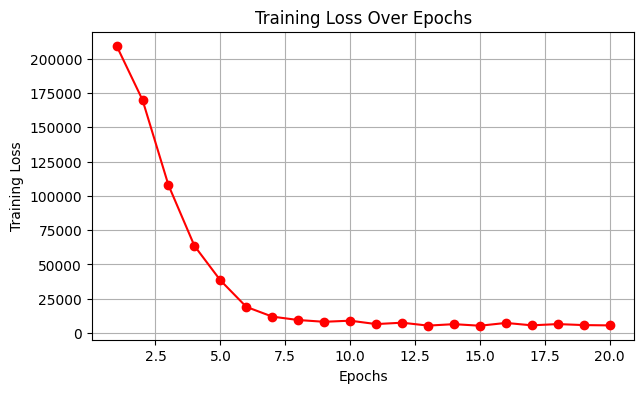

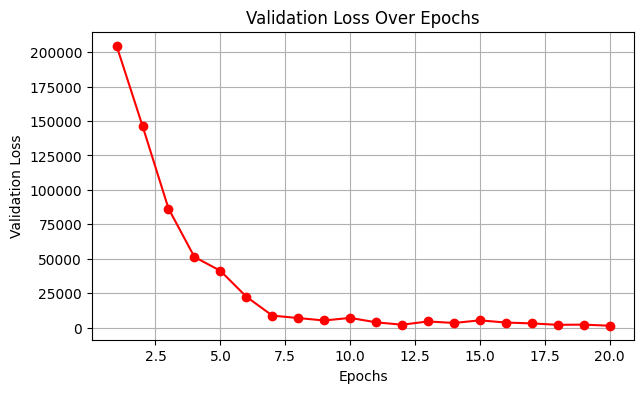

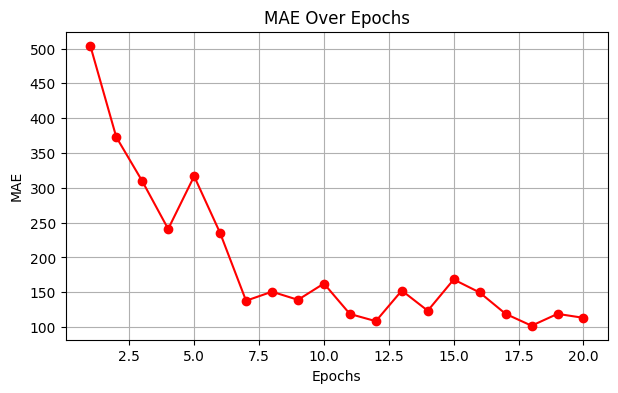

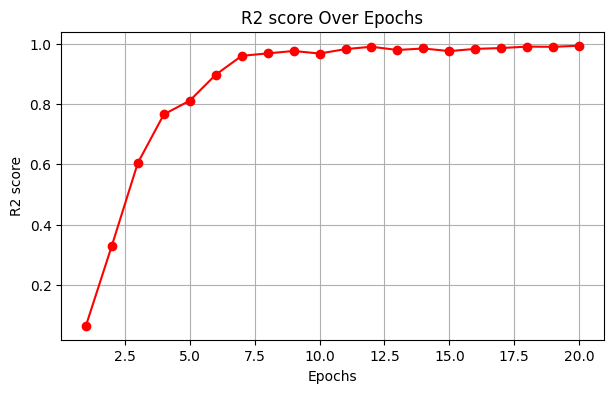

✅ Plots saved to: results\CryptoInformer_2025-04-10_15-26-05
✅ Metric histories saved to: results\CryptoInformer_2025-04-10_15-26-05\metric_histories.pth


In [20]:
save_training_plots_and_metric_history(
    training_loss_history, validation_loss_history, mae_history, r2_history, type(model).__name__
)

## 3. Test

In [21]:
final_evaluation_loss, final_mae, final_r2 = evaluate_crypto_model(model, test_loader, normalizer)
print(f"Loss: {final_evaluation_loss:.4f}, MAE: {final_mae:.4f}, R2: {final_r2:.4f}")

Loss: 1822.6746, MAE: 118.3886, R2: 0.9918
